# Collaboration and Competition

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the third project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
from unityagents import UnityEnvironment
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import torch

from config import DDPGConfig, DDPGPERConfig
from ddpg import DDPG
from environment import UnityGymAdapter
from models import Actor

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Tennis.app"`
- **Windows** (x86): `"path/to/Tennis_Windows_x86/Tennis.exe"`
- **Windows** (x86_64): `"path/to/Tennis_Windows_x86_64/Tennis.exe"`
- **Linux** (x86): `"path/to/Tennis_Linux/Tennis.x86"`
- **Linux** (x86_64): `"path/to/Tennis_Linux/Tennis.x86_64"`
- **Linux** (x86, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86"`
- **Linux** (x86_64, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86_64"`

For instance, if you are using a Mac, then you downloaded `Tennis.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Tennis.app")
```

In [2]:
env = UnityEnvironment(file_name="Tennis_Linux/Tennis.x86_64")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

In this environment, two agents control rackets to bounce a ball over a net. If an agent hits the ball over the net, it receives a reward of +0.1.  If an agent lets a ball hit the ground or hits the ball out of bounds, it receives a reward of -0.01.  Thus, the goal of each agent is to keep the ball in play.

The observation space consists of 8 variables corresponding to the position and velocity of the ball and racket. Two continuous actions are available, corresponding to movement toward (or away from) the net, and jumping. 

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.        ]


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agents and receive feedback from the environment.

Once this cell is executed, you will watch the agents' performance, if they select actions at random with each time step.  A window should pop up that allows you to observe the agents.

Of course, as part of the project, you'll have to change the code so that the agents are able to use their experiences to gradually choose better actions when interacting with the environment!

In [5]:
for i in range(1, 6):                                      # play game for 5 episodes
    env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
    states = env_info.vector_observations                  # get the current state (for each agent)
    scores = np.zeros(num_agents)                          # initialize the score (for each agent)
    while True:
        actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
        actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
        env_info = env.step(actions)[brain_name]           # send all actions to tne environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        scores += env_info.rewards                         # update the score (for each agent)
        states = next_states                               # roll over states to next time step
        if np.any(dones):                                  # exit loop if episode finished
            break
    print('Score (max over agents) from episode {}: {}'.format(i, np.max(scores)))

Score (max over agents) from episode 1: 0.0
Score (max over agents) from episode 2: 0.0
Score (max over agents) from episode 3: 0.0
Score (max over agents) from episode 4: 0.0
Score (max over agents) from episode 5: 0.09000000171363354


When finished, you can close the environment.

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```

In [6]:
# Instanciate environment - Uncomment if you don't already have an env running
# env = UnityEnvironment(file_name="Reacher_Linux/Reacher.x86_64")
# Wraps environment to have gym-like API
env = UnityGymAdapter(env)

# Define training configurations
configs = {"Vanilla": DDPGConfig(), "Prioritized": DDPGPERConfig()}
# Instantiate scores dict, which will contain sores for each config
scores = {}

In [7]:
# Train each config for 2000 episodes
for name, config in configs.items():
    print(f"\nTraining: {name}")
    agent = DDPG(env.state_size, env.action_size, config)
    scores[name] = agent.train(env, 2000)
    agent.save_model(name.lower().replace(" ", "_") + '.pt')


Training: Vanilla
Episode 99	Average Score: 0.00, Last Score: 0.10
Episode 199	Average Score: 0.02, Last Score: 0.00
Episode 299	Average Score: 0.02, Last Score: 0.00
Episode 399	Average Score: 0.00, Last Score: 0.00
Episode 499	Average Score: 0.00, Last Score: 0.00
Episode 599	Average Score: 0.00, Last Score: 0.00
Episode 699	Average Score: 0.00, Last Score: 0.00
Episode 799	Average Score: 0.00, Last Score: 0.00
Episode 899	Average Score: 0.03, Last Score: 0.09
Episode 999	Average Score: 0.08, Last Score: 0.10
Episode 1099	Average Score: 0.09, Last Score: 0.10
Episode 1199	Average Score: 0.10, Last Score: 0.09
Episode 1299	Average Score: 0.17, Last Score: 0.10
Episode 1399	Average Score: 0.24, Last Score: 1.00
Episode 1499	Average Score: 0.43, Last Score: 0.10
Episode 1599	Average Score: 0.71, Last Score: 2.40
Episode 1699	Average Score: 0.65, Last Score: 0.10
Episode 1799	Average Score: 0.48, Last Score: 0.30
Episode 1899	Average Score: 0.51, Last Score: 0.70
Episode 1999	Average Sc

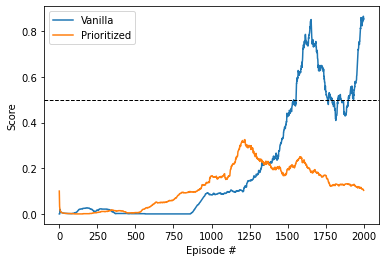

In [14]:
# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
for name, score in scores.items():
    plt.plot(np.arange(len(score)), score, label=name)
plt.axhline(y=0.5, linestyle='--', color='black', linewidth=1)
plt.legend()
plt.ylabel("Score")
plt.xlabel("Episode #")
plt.show()

In [15]:
for name in configs:
    t = np.argmax(np.where(np.array(scores[name])>0.5, 1, 0))
    if t>0:
        print(f"{name} solved the environment in {t} episode")
    else:
        print(f"{name} did not solve the environment")

Vanilla solved the environment in 1555 episode
Prioritized did not solve the environment


### 5. Render Agent

Now it is time to render the agent !

In [10]:
# Chose one of Vanilla, Prioritized
config = "Vanilla"

file_name = config.lower().replace(" ", "_") + ".pt"

# Load model
model = Actor(env.state_size, env.action_size, 0) 
model.load_state_dict(torch.load(file_name, map_location="cpu"))
model.eval()

Actor(
  (fc1): Linear(in_features=24, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=64, bias=True)
  (fc4): Linear(in_features=64, out_features=2, bias=True)
  (bn1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

In [11]:
def get_actions(model, states):
        states = torch.from_numpy(states).float().unsqueeze(0)

        actions = []
        with torch.no_grad():
            for state in states:
                action = model(state)
                actions.append(action.detach().numpy())

        return np.array(actions).squeeze()

In [12]:
states = env.reset(train_mode=False)               # reset the environment
score = 0                                          # initialize the score
while True:
    action = get_actions(model, states)
    next_states, rewards, dones = env.step(action)   
    score += np.mean(rewards)    
    states = next_states                             
    if any(dones):                                       
        break
    
print("Score: {}".format(score))

Score: 2.600000038743019


In [13]:
env.close()